In [1]:
import dataset
import utils
import reference_impl as ref
import predictors
import model
import os


In [2]:
cfg = utils.Config(
    num_rx_antennas=1,
    num_tx_antennas=32,
    num_subcarriers=80,
    train_test_split=0.8,
    data_root="../data/dataset2",
    reduce_pca_overhead=False,
    total_bits=512,
    results_save_path="../results"
    # duplicate_data=1,
    # data_snr=-1
)


dataset.combine_time_series_paths(
    cfg.data_root,
    list(range(33)),
    2.5e9,
    "train_set.pickle"
)
dataset.combine_time_series_paths(
    cfg.data_root,
    list(range(34, 40)),
    2.5e9,
    "test_set.pickle"
)

train_set = dataset.dataset_from_path(os.path.join(cfg.data_root, "train_set.pickle"), cfg)
test_set = dataset.dataset_from_path(os.path.join(cfg.data_root, "test_set.pickle"), cfg)

## Offline Training
import matlab.engine

matlab = matlab.engine.start_matlab()
pca = ref.ReferencePCA(cfg, matlab)
model.train_or_load(pca, cfg.pca_path, cfg.retrain_all, train_set.csi_samples)  # pca.fit() includes reduce overhead
zdl_train = pca.process(train_set.csi_samples)  # N * zdl_len

Saving files to  ../data/dataset2/train_set.pickle
Number of samples (14320, 1, 32, 1, 80)
Saving files to  ../data/dataset2/test_set.pickle
Number of samples (2655, 1, 32, 1, 80)


In [8]:
## Train Predictor
# trunc_components = 16
# trunc_train = zdl_train[:, trunc_components]
# 
predictor = predictors.TopVARPredictor(cfg, 20)
model.train_or_load(predictor, cfg.predictor_path, cfg.retrain_all, zdl_train)

In [9]:
import numpy as np
max_lag = max(predictor.imag_lag_order, predictor.real_lag_order)
predicted_shape = (zdl_train.shape[0] - max_lag, *zdl_train.shape[1:])
predicted_zdl = np.zeros_like(zdl_train)
for i in range(max_lag, len(zdl_train)):
    window = zdl_train[i-max_lag : i]
    predicted_zdl[i] = predictor.process(window)

KeyboardInterrupt: 

<Figure size 640x480 with 0 Axes>

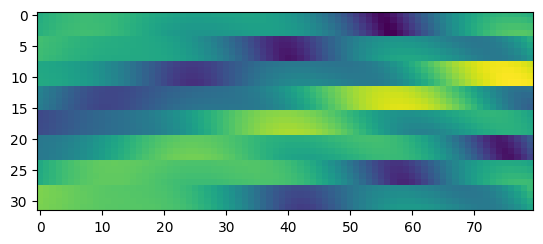

<Figure size 640x480 with 0 Axes>

In [5]:
import matplotlib.pyplot as plt
ori = np.expand_dims(train_set[10].csi, axis=0)
plt.imshow(np.squeeze(np.abs(ori)))
plt.figure()


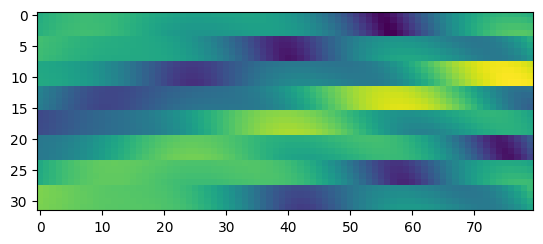

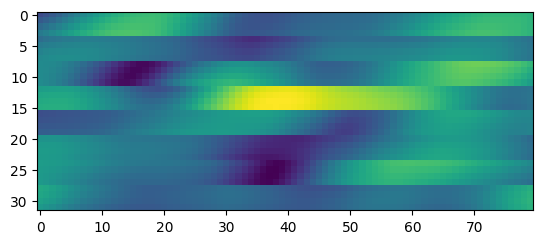

In [7]:
def plot(zdl):
    plt.figure()
    zdl = np.expand_dims(zdl, axis=0)
    recovered = pca.decode(zdl)
    plt.imshow(np.squeeze(np.abs(recovered)))
    
idx = 10
single_zdl = zdl_train[idx]
single_pred = predicted_zdl[idx]

plot(single_zdl)
plot(single_pred)

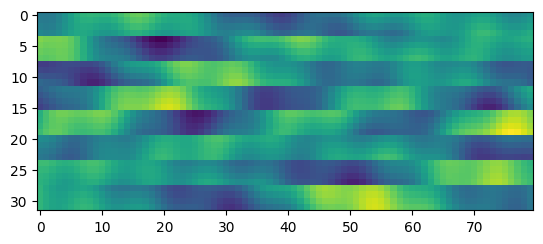

In [19]:
error = single_pred - single_zdl
plot(error)

np.complex64(0j)

In [ ]:
## Error Compression
error_compressor = ref.ReferenceKmeans(cfg, matlab)
model.train_or_load(error_compressor, cfg.kmeans_path, cfg.retrain_all, prediction_error)

# DL and UL each get trained pca, predictor, and error_compressor